# Project: WeRateDog Udacity 


# 1. Introduction
WeRateDogs is a twitter handle that rates pictures of dogs that are posted on twitter by different people.
In this project, various information about dogs is pulled from the WeRateDogs twitter handle , twitter APIs call,and programmatically downloaded additional tsv file for analysis and cleaning. Further analysis will be carried out on data colllected to answer below questions

i.What percentage of people dispatched picture that were not dogs?

ii.What average month does WeRateDogs get the most appointment?

iii.If there exist a correlation between favorite count and rating numerator?

iv.What is the percentage of favorite counts for dissimilar dog identifer?

# 2. Data Gathering
Basic information shall be used in the wrangling process from three different sources as stated below:

1.A csv file provided by Udacity with 2500 tweets by WeRateDogs twitter handle

2.Breed prediction of Dogs file downloaded programatically from Udacity's server

3.Additional data retrieved from twitter's API calls about tweet-id used to generate retweet counts and favorite counts

In [87]:
# import necessary liberaries and packages
import pandas as pd
import numpy as np
import requests
import os
import re
import tweepy
from tweepy import OAuthHandler
import json
import sys
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [88]:
# Loading tweets data manually
df_arc = pd.read_csv('twitter-archive-enhanced.csv')
df_arc.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2.Programaticaaly download tsv document from Udacity server (image_predictions.tsv)

In [89]:
folder_info = 'image_predictions'

# if not os.path.exists(folder_info):
#     os.makedirs(folder_info)
    
# url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    
# response = requests.get(url)
# with open(os.path.join(folder_info, url.split('/')[-1]), mode = 'wb') as file:
#     file.write(response.content)

tw_pred = pd.read_csv(folder_info+'/'+'image-predictions.tsv', sep='\t')
tw_pred    

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


3. Additional data retrieved from Twitter's API calls (tweet_json.txt)

In [4]:
# Query twitter API for each tweet in archieve and save JSON in text file
# keys are hidden to conform with twitter's API terms and conditions
consumer_key =  # 'YOUR CONSUMER KEY'
consumer_secret = # 'YOUR CONSUMER SECRET'
access_token = # 'YOUR ACCESS TOKEN'
access_secret = # 'YOUR ACCESS SECRET'

auth = OAuthHandler(consumer_key, consumer_secret )
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, retry_count=5, retry_delay=7, retry_errors=set([401,404,500,503]), wait_on_rate_limit=True)

In [20]:
# Twitter API for JSON data should be query for each ID in the twitter Archive
tweet_ids = df_arc.tweet_id.values

count = 0
fails_dict = {}
start = timer()
# Each tweet's returned JSON is save as new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop runs approxiamtely 20-30min due to twitter's boundary rate
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ":" + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            print("success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except Exception as e:
            print("fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end-start)
print(fails_dict)
    

1:892420643555336193
success
2:892177421306343426
success
3:891815181378084864
success
4:891689557279858688
success
5:891327558926688256
success
6:891087950875897856
success
7:890971913173991426
success
8:890729181411237888
success
9:890609185150312448
success
10:890240255349198849
success
11:890006608113172480
success
12:889880896479866881
success
13:889665388333682689
success
14:889638837579907072
success
15:889531135344209921
success
16:889278841981685760
success
17:888917238123831296
success
18:888804989199671297
success
19:888554962724278272
success
20:888202515573088257
fail
21:888078434458587136
success
22:887705289381826560
success
23:887517139158093824
success
24:887473957103951883
success
25:887343217045368832
success
26:887101392804085760
success
27:886983233522544640
success
28:886736880519319552
success
29:886680336477933568
success
30:886366144734445568
success
31:886267009285017600
success
32:886258384151887873
success
33:886054160059072513
success
34:885984800019947520


Rate limit reached. Sleeping for: 373


success
2070:671134062904504320
success
2071:671122204919246848
success
2072:671115716440031232
success
2073:671109016219725825
success
2074:670995969505435648
success
2075:670842764863651840
success
2076:670840546554966016
success
2077:670838202509447168
success
2078:670833812859932673
success
2079:670832455012716544
success
2080:670826280409919488
success
2081:670823764196741120
success
2082:670822709593571328
success
2083:670815497391357952
success
2084:670811965569282048
success
2085:670807719151067136
success
2086:670804601705242624
success
2087:670803562457407488
success
2088:670797304698376195
success
2089:670792680469889025
success
2090:670789397210615808
success
2091:670786190031921152
success
2092:670783437142401025
success
2093:670782429121134593
success
2094:670780561024270336
success
2095:670778058496974848
success
2096:670764103623966721
success
2097:670755717859713024
success
2098:670733412878163972
success
2099:670727704916926465
success
2100:670717338665226240
success


In [90]:
# Extracting data to check
tweets = []
for line in open('tweet_json.txt', 'r'):
    tweets.append(json.loads(line))
# print one json object for purpose of reference
tweets[1]

{'created_at': 'Tue Aug 01 00:17:27 +0000 2017',
 'id': 892177421306343426,
 'id_str': '892177421306343426',
 'full_text': "This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",
 'truncated': False,
 'display_text_range': [0, 138],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892177413194625024,
    'id_str': '892177413194625024',
    'indices': [139, 162],
    'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg',
    'url': 'https://t.co/0Xxu71qeIV',
    'display_url': 'pic.twitter.com/0Xxu71qeIV',
    'expanded_url': 'https://twitter.com/dog_rates/status/892177421306343426/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 1055, 'h': 1200, 'resize': 'fit'},
     'small': {'

In [91]:
# generate data list as of json.txt

twits_list = []
for data_json in tweets:
    twits_list.append({"tweet_id":data_json["id_str"],
                      "favorite_count":int(data_json["favorite_count"]),
                      "retweet_count":int(data_json["retweet_count"])})
    
# generating DataFrame
tw_tweets = pd.DataFrame(twits_list, columns = ["tweet_id", "favorite_count", "retweet_count"])

    
tw_tweets 

,tweet_id,favorite_count,retweet_count
0,892420643555336193,33687,6968
1,892177421306343426,29220,5272
2,891815181378084864,21969,3464
3,891689557279858688,36774,7190
4,891327558926688256,35170,7712
...,...,...,...
2322,666049248165822465,88,36
2323,666044226329800704,246,115
2324,666033412701032449,100,36
2325,666029285002620928,112,39


# Assessing Data

In other to detect quality issues, visual assessment </br> was deployed using excel spreadsheet.

In [92]:
df_arc.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [93]:
tw_pred.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [94]:
tw_tweets.head(5)

,tweet_id,favorite_count,retweet_count
0,892420643555336193,33687,6968
1,892177421306343426,29220,5272
2,891815181378084864,21969,3464
3,891689557279858688,36774,7190
4,891327558926688256,35170,7712


# Data Valuation

In [95]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [96]:
df_arc.isnull()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
1,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
2,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
3,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
4,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
2352,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
2353,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
2354,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False


In [97]:
df_arc.tweet_id.duplicated().sum()

0

In [98]:
df_arc.text.duplicated().sum()

0

In [99]:
tw_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [100]:
tw_pred.isnull().sum().sum()

0

In [101]:
tw_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2327 non-null   object
 1   favorite_count  2327 non-null   int64 
 2   retweet_count   2327 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


### Quality issues
df_arc table

i.Data type discrepancy as both df_arc and tw_pred has int64 as dtype for tweets_id while tw_tweets has object as its own. 

ii.Dtype of timestamp column is object as a subsitute for datetime. Converting this column to month will be paramount for our analysis.

iii.Dog names such as a,actually,an,just,this,unacceptable, etc present in df_arc table . This blunder occured during the extraction of names from the text column. For this project,insight will not be affected by this column as it will be dropped or left the way it is.

iv.Denominators equals 170,0,50 etc are irregularities in the rating system . This will be adderessed .

v.Rating_numerator column has shockingly high values which can lead to wrong/incorrect insights throughout the analysis and visualization phase.

vi.Correct value was not well extracted from the text column in that some dogs have values in two dog phase columns .For example Doggo and floofer at same time .

vii.Instances where string object 'none' is characterized as nan.

viii.There are rows that comprises dogs in dissimilar phases at thesame time. For example doggo and puppa, doggo and puper , doggo and floofer.

tw_pred table

.p1,p2,p3 columns sometimes have incorrect predictions

.Irregularity of lower and upper case styling in columns of p1,p2,p3.

tw_tweets table

. Some tweets were deleted which lead to missing tweet ids


### Tidiness issues
1.Text,email which are two variables are in one column

2.Four(4) columns of doggo,floofer,pupper and puppo resulted from the split of one variable phase

3.Different tables of df_arc and tw_tweets have same type of experimental unit

## Cleaning Data


In [102]:
# Make copies of original pieces of data
arc_neat = df_arc.copy()
pred_neat = tw_pred.copy()
tweets_data_neat = tw_tweets.copy()

### arc_neat table

#### Define
.Convert data type of tweet_id for both arc_neat and pred_neat tables from int64 to object

#### Code

In [103]:
arc_neat.tweet_id = arc_neat.tweet_id.astype(str)
pred_neat.tweet_id = pred_neat.tweet_id.astype(str)

#### Checking

In [104]:
arc_neat.tweet_id.dtype

dtype('O')

In [105]:
pred_neat.tweet_id.dtype

dtype('O')

#### Define
. Change timestamp column to month via datetime
. Remove month values
. Rename column as 'month'

#### Code

In [106]:
arc_neat.timestamp = pd.to_datetime(arc_neat.timestamp)
arc_neat.timestamp.dtype

datetime64[ns, UTC]

In [107]:
arc_neat.timestamp = arc_neat.timestamp.dt.month.values 

In [108]:
arc_neat.rename(columns={'timestamp':'month'}, inplace=True)

#### Checking

In [109]:
arc_neat.month

0        8
1        8
2        7
3        7
4        7
        ..
2351    11
2352    11
2353    11
2354    11
2355    11
Name: month, Length: 2356, dtype: int64

#### Define
. For rating_denominator column not equals 10, change all cases

#### Code

In [110]:
not_ten_indices = arc_neat.query("rating_denominator !=10")['rating_denominator'].index

In [111]:
for index in not_ten_indices:
    arc_neat.at[index, 'rating_denominator'] = 10

#### Checking

In [112]:
# Empty series will be returned here to confirm it
arc_neat.query("rating_denominator !=10")['rating_denominator']

Series([], Name: rating_denominator, dtype: int64)

#### Define
.For rating_numerator greater than 15 substitute all values with the average value of the col
.Data type should be changed to integer

#### Code

In [113]:
# Before clean, check value
arc_neat.rating_numerator.values[979]

1776

In [114]:
arc_neat.loc[arc_neat.rating_numerator > 15, 'rating_numerator'] = arc_neat.rating_numerator.mean()
arc_neat.rating_numerator = arc_neat.rating_numerator.astype(int)

#### Checking

In [115]:
arc_neat.rating_numerator.values[979]

13

#### Define
.From arc_neat table remove inacceptable dog names

#### Code

In [116]:
dog_names = arc_neat.name.values

for nam in dog_names:
    if nam.islower():
        arc_neat.name.replace(nam, '', inplace=True)

#### Checking

In [117]:
# Columns such as 'a' with lowercase is no more
arc_neat.name.values

array(['Phineas', 'Tilly', 'Archie', ..., '', '', 'None'], dtype=object)

#### Define
.In pred_neat table,drop columns p3,p3_conf,p3_dog,p2,p2_conf,p2_dog,jpg_url
.prediction p1 column entries is Capitalized

#### Code

In [118]:
pred_neat.drop(['p3', 'p3_conf', 'p3_dog', 'p2', 'p2_conf', 'p2_dog', 'jpg_url'],axis=1, inplace=True)
pred_neat.p1 = pred_neat.p1.str.title()

#### Checking

In [119]:
pred_neat.head()

,tweet_id,img_num,p1,p1_conf,p1_dog
0,666020888022790149,1,Welsh_Springer_Spaniel,0.465074,True
1,666029285002620928,1,Redbone,0.506826,True
2,666033412701032449,1,German_Shepherd,0.596461,True
3,666044226329800704,1,Rhodesian_Ridgeback,0.408143,True
4,666049248165822465,1,Miniature_Pinscher,0.560311,True


#### Tidiness Issues

#### Define
.The tweet_url is extracted from text column and placed in own column

#### Code

In [120]:
arc_neat['tweet_url'] = arc_neat.text.str.extract('(https:\/\/t\.co\/[a-zA-Z0-9_]+)', expand=True)
arc_neat['text'] = arc_neat.text.str.extract("([\w;?:?@?\s\.\"']+)", expand=True)

#### Checking

In [121]:
arc_neat.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,month,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,tweet_url
0,892420643555336193,NaN,NaN,8,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,https://t.co/MgUWQ76dJU
1,892177421306343426,NaN,NaN,8,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,https://t.co/0Xxu71qeIV
2,891815181378084864,NaN,NaN,7,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,https://t.co/wUnZnhtVJB
3,891689557279858688,NaN,NaN,7,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,https://t.co/tD36da7qLQ
4,891327558926688256,NaN,NaN,7,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,https://t.co/AtUZn91f7f


#### Define
.Move variables doggo,floofer,pupper, and puppo into identifer column and then drop the columns
.Exchange None with nan

#### Code

In [122]:
arc_neat['identifer'] = arc_neat['doggo']+arc_neat['floofer']+arc_neat['pupper']+arc_neat['puppo']

In [123]:
arc_neat.identifer.unique()

array(['NoneNoneNoneNone', 'doggoNoneNoneNone', 'NoneNoneNonepuppo',
       'NoneNonepupperNone', 'NoneflooferNoneNone', 'doggoNoneNonepuppo',
       'doggoflooferNoneNone', 'doggoNonepupperNone'], dtype=object)

The above array depicts some dogs to be in two different identifer at thesame time.Here tweets had two dogs in the picture which were pulled out from tweets columns. My insights is as seen below:

.Initially I assumed it was shy doggo but on the contrary is a Rare Canadian Floofer Owl.
.Again we see Buke(pupper) and Dexter(doggo).Although pupper resembles doggo precisely.Together 12\10 is tame at thesame time </br>

However, the case "doggo,floofer" and "doggo,puppo" will be thoroughly cleaned since it displays the "doggo,floofer" as floofer and the case "doggo,puppa" as puppo.Thus to avoid partiality in case of future analysis, equal distribution of doggo or pupper will be used in the second case which are twelve(12) in number.

In [124]:
fresh_values=[]
for value in arc_neat.identifer.values:
# nov_string = "Here is none sample stnonring"
    pattern = 'None'
    # exchange all events of attribute None with an empty string
    mod_string = re.sub(pattern, '', value)
    fresh_values.append(mod_string)
fresh_values
# arc_neat.identifer.replace(r'None', '', regex=True)
arc_neat.identifer = fresh_values
arc_neat.identifer.unique()



array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

In [125]:
# exchange all '' with nan 
for value in arc_neat.identifer.values:
    arc_neat.identifer.replace(to_replace='', value=np.nan, inplace=True)


In [126]:
# transform event of doggopuppo to puppo as tweet text original
dogo_pupo_index = arc_neat.query('identifer=="doggopuppo"').index
arc_neat.identifer.iloc[dogo_pupo_index]='puppo'

# transform event of doggofloofer to floofer as per tweet text original
dogo_flufo_index = arc_neat.query('identifer=="doggofloofer"').index
arc_neat.identifer.iloc[dogo_flufo_index]='floofer'

C:\Users\odujo\AppData\Local\Temp\ipykernel_19432\4020590521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arc_neat.identifer.iloc[dogo_pupo_index]='puppo'
C:\Users\odujo\AppData\Local\Temp\ipykernel_19432\4020590521.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arc_neat.identifer.iloc[dogo_flufo_index]='floofer'


### Checking 

In [127]:
arc_neat.identifer.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggopupper'],
      dtype=object)

In [128]:
# transform event of doggopupper to pupper as per tweet text original
dogo_puppa_index = arc_neat.query('identifer=="doggopupper"').index
arc_neat.identifer.iloc[dogo_puppa_index]='pupper'


# 12 sporadic values to exchange events evenly of doggopupper
identifers = ['doggo', 'pupper']*6

value=0
for index in dogo_puppa_index:
    arc_neat.at[index, 'identifer']=identifers[value]
    value+=1

C:\Users\odujo\AppData\Local\Temp\ipykernel_19432\3459963415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arc_neat.identifer.iloc[dogo_puppa_index]='pupper'


### Checking 

In [129]:
arc_neat.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'month',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_url', 'identifer'],
      dtype='object')

In [130]:
# drop columns that are extraneous to our investigation
arc_neat.drop(['retweeted_status_id','retweeted_status_user_id',
               'retweeted_status_timestamp','source',
              'expanded_urls','in_reply_to_status_id',
              'in_reply_to_user_id','doggo','floofer',
               'pupper','puppo','tweet_url'],axis=1,inplace=True)

### Checking

In [131]:
arc_neat.columns

Index(['tweet_id', 'month', 'text', 'rating_numerator', 'rating_denominator',
       'name', 'identifer'],
      dtype='object')

In [132]:
arc_neat.identifer.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

In [133]:
arc_neat.head(2)

,tweet_id,month,text,rating_numerator,rating_denominator,name,identifer
0,892420643555336193,8,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN
1,892177421306343426,8,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN


#### Define
.convert all events of 'None'in identifer column to nan

#### Code

In [134]:
for value in arc_neat.name.values:
    arc_neat.name.replace(to_replace='None', value = np.nan,inplace = True)

### Checking

In [135]:
arc_neat.head(2)

,tweet_id,month,text,rating_numerator,rating_denominator,name,identifer
0,892420643555336193,8,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN
1,892177421306343426,8,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN


#### Define
Combine arc_neat table with tweets_neat table joining on tweet_id 

#### Code

In [136]:
# crisscross column to which to join on
all_columns = pd.Series(list(arc_neat) + list(pred_neat) + list(tweets_data_neat))
all_columns[all_columns.duplicated()]

7     tweet_id
12    tweet_id
dtype: object

In [137]:
# merge arc_neat and tweets_data_neat table
new_arc_neat = pd.merge(arc_neat, tweets_data_neat, on='tweet_id', how='inner')

### Checking

In [138]:
new_arc_neat.head(2)

,tweet_id,month,text,rating_numerator,rating_denominator,name,identifer,favorite_count,retweet_count
0,892420643555336193,8,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,33687,6968
1,892177421306343426,8,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,29220,5272


#### Define 
.merge new_arc_neat table with pred_neat table to create a master dataset

#### Code

In [139]:
master = pd.merge(new_arc_neat, pred_neat, on='tweet_id',how='inner')

### Checking

In [140]:
master.head(2)

,tweet_id,month,text,rating_numerator,rating_denominator,name,identifer,favorite_count,retweet_count,img_num,p1,p1_conf,p1_dog
0,892420643555336193,8,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,33687,6968,1,Orange,0.097049,False
1,892177421306343426,8,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,29220,5272,1,Chihuahua,0.323581,True


In [141]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2057 non-null   object 
 1   month               2057 non-null   int64  
 2   text                2057 non-null   object 
 3   rating_numerator    2057 non-null   int32  
 4   rating_denominator  2057 non-null   int64  
 5   name                1486 non-null   object 
 6   identifer           318 non-null    object 
 7   favorite_count      2057 non-null   int64  
 8   retweet_count       2057 non-null   int64  
 9   img_num             2057 non-null   int64  
 10  p1                  2057 non-null   object 
 11  p1_conf             2057 non-null   float64
 12  p1_dog              2057 non-null   bool   
dtypes: bool(1), float64(1), int32(1), int64(5), object(5)
memory usage: 202.9+ KB


### Saving Data

In [142]:
# store data in "twitter_archive_master.csv" file
master.to_csv("twitter_archive_master.csv", index=False)

In [143]:
master = pd.read_csv("twitter_archive_master.csv")

In [144]:
master.tail(2)

,tweet_id,month,text,rating_numerator,rating_denominator,name,identifer,favorite_count,retweet_count,img_num,p1,p1_conf,p1_dog
2055,666029285002620928,11,This is a western brown Mitsubishi terrier. Up...,7,10,NaN,NaN,112,39,1,Redbone,0.506826,True
2056,666020888022790149,11,Here we have a Japanese Irish Setter. Lost eye...,8,10,NaN,NaN,2282,419,1,Welsh_Springer_Spaniel,0.465074,True


## Analyzing and Visualizing Data
In this section, quality insights will be generated from the data that was successfully cleaned.

### Insights:
i.According to the image prediction algorithm, what percentage of people dispatched pictures that were not that of dogs?

ii.What average month does WeRateDogs get the most appointment?

iii.Between favorite counts and rating, is there a correlation?
iv.What is the percentage of favorite counts for the dissimilar dog identifer?

### First Insight
Percentage of people that dispatched pictures that were not dogs based on image prediction algorithm

In [145]:
# people  percentage not dogs
per_not_dogs = (master.p1_dog.value_counts().values[1] / master.p1_dog.value_counts().sum()) *100
per_not_dogs

26.154594069032573

In [146]:
# people percentage dogs
per_dogs = (master.p1_dog.value_counts().values[0] / master.p1_dog.value_counts().sum()) *100
per_dogs

73.84540593096743

In [147]:
values = master.p1_dog.value_counts(normalize=True).values
animal = ['dogs', 'not_dogs']

### Visualization

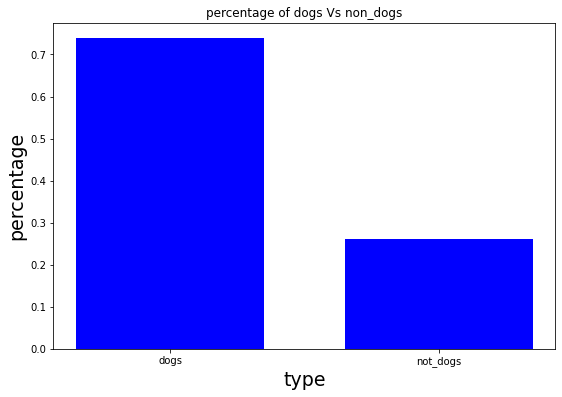

In [148]:
# setting figure size and label
fig = plt.figure(figsize = (9,6))

plt.bar(animal,values,color='blue',width=0.7)
plt.title('percentage of dogs Vs non_dogs')
plt.xlabel('type',fontsize=19)
plt.ylabel('percentage',fontsize=19)
plt.show()

### Deduction

.The bar plot above depicts that 26% of people did not stick to posting dog pictures based on the image prediction algorithm. Comparatively, 26% is huge and according to Zitek & Jordan (2017) entitle people do not follow instructions as they see it as 'unfair' imposition on them. This implies that certain percentage of entitled people are part of the WeRateDogs appointees .



### second Insight

.Average month spreading of WeRateDogs from 2015-11-15 to 2017-08-01 by user rendezvous

In [149]:
mean_fav_count = master.groupby('month')['favorite_count'].mean().values

In [150]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

### Visualization

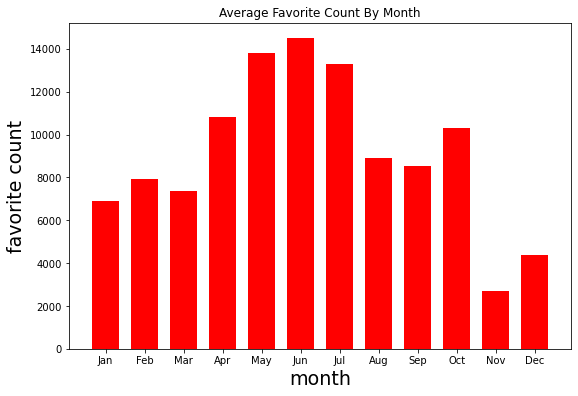

In [151]:
# setting figure size and labels
fig = plt.figure(figsize = (9,6))

plt.bar(months,mean_fav_count,color='Red',width=0.7)
plt.xlabel('month',fontsize=19)
plt.ylabel('favorite count',fontsize=19)
plt.title('Average Favorite Count By Month')
plt.show()

### Deduction

.The bar plot above shows that the month with the most Rendezvous on the average for the past two years on the WeRateDogs twitter account is Jun.


### Third Insight

.Correlation Between Favorite_count and rating_numerator

In [152]:
favorite_count = master.favorite_count.values
rating_numerator = master.rating_numerator.values

In [153]:
correlation = master.favorite_count.corr(master.rating_numerator)
correlation

0.3552502474789611

### Visualization

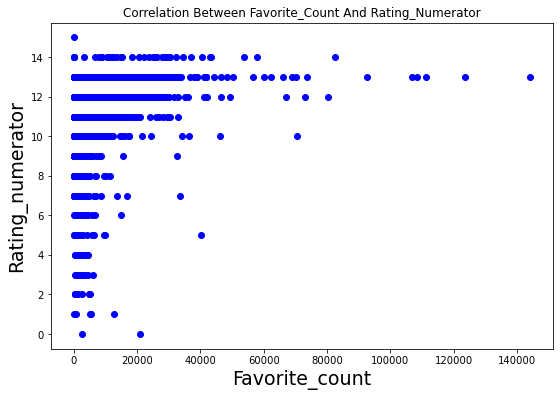

In [154]:
# setting figure size and labels
fig = plt.figure(figsize=(9,6))

plt.scatter(favorite_count,rating_numerator, color='blue')
plt.xlabel('Favorite_count',fontsize=19)
plt.ylabel('Rating_numerator',fontsize=19)
plt.title("Correlation Between Favorite_Count And Rating_Numerator")
plt.show()


### Deduction

.The correlation here is abstemiously positive with a value of 0.36. My thought before now based on the analysis thus far is that I expected a very strong correlation between the two variables of Favorite_count and Rating_numerator.

### Fourth Insight

. Average favorite_count for dog identifers

In [155]:
mean_fav_count = master.groupby('identifer')['favorite_count'].mean().values
dog_identifer = master.groupby('identifer')['favorite_count'].mean().index

### Visualization 

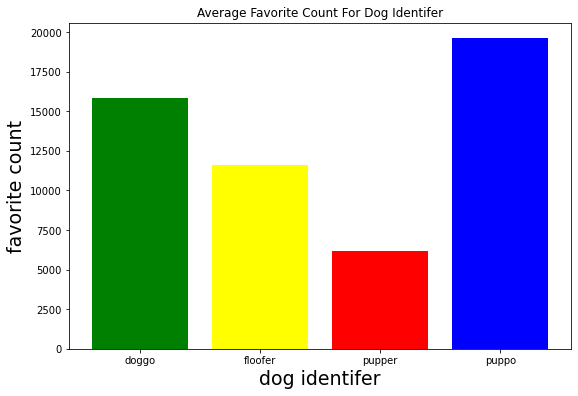

In [156]:
# setting figure size and labels
fig = plt.figure(figsize=(9,6))

plt.bar(dog_identifer,mean_fav_count, color=['green','yellow','red','blue'])
plt.xlabel('dog identifer',fontsize=19)
plt.ylabel('favorite count',fontsize=19)
plt.title("Average Favorite Count For Dog Identifer")
plt.show()

### Conclusion

.The bar chart depicts that dogs in the puppo identifer had more favorite count on the average on WeRateDogs twitter account while pupper had the least from November 2015 to August 2017 

### Reference

Emily M.Zitek, Alexander H.Jordan(2017),'Psychological Entitlement Predicts Failure to Follow Instructions',Journal of Social Psychological and Personality Science.[Online]Available from:https://www.sciencedaily.com/releases/2017/12/171220121733.htm (Accessed: 17th September 2022)